In [2]:
!gdown 1orMtLhJt3rQl3pMoLm31eh-SmDG74W1K

Downloading...
From (original): https://drive.google.com/uc?id=1orMtLhJt3rQl3pMoLm31eh-SmDG74W1K
From (redirected): https://drive.google.com/uc?id=1orMtLhJt3rQl3pMoLm31eh-SmDG74W1K&confirm=t&uuid=c14d8033-4d54-4827-bd74-5e1deb5b6e2f
To: /kaggle/working/ReCTS.zip
100%|███████████████████████████████████████| 1.92G/1.92G [00:10<00:00, 178MB/s]


In [3]:
!unzip -q /kaggle/working/ReCTS.zip

In [4]:
import os
import glob
import json
import cv2
import numpy as np
import shutil
from sklearn.model_selection import train_test_split

# --- Configuration ---
IMG_SOURCE_DIR = "/kaggle/working/img"
LABEL_SOURCE_DIR = "/kaggle/working/gt"

# New output directory structure based on your request
OUTPUT_ROOT = "/kaggle/working/content/train_data"
OUTPUT_REC_DIR = os.path.join(OUTPUT_ROOT, "rec")
OUTPUT_TRAIN_IMG_DIR = os.path.join(OUTPUT_REC_DIR, "train")
OUTPUT_TEST_IMG_DIR = os.path.join(OUTPUT_REC_DIR, "test")

# Train/Validation split ratio
VAL_SPLIT_RATIO = 0.1 # 10% for validation
# ---------------------

def get_axis_aligned_crop(image, points):
    """
    Takes a full image and 4 (x,y) polygon points, and returns
    the simple, horizontal bounding box crop that encloses them.
    """
    # Convert points to a numpy array, shape (4, 2)
    # The JSON has 8 points [x1, y1, x2, y2, x3, y3, x4, y4]
    points_arr = np.array(points, dtype=np.float32).reshape(4, 2)

    # Find the min/max x and y coordinates
    x_min = int(np.min(points_arr[:, 0]))
    x_max = int(np.max(points_arr[:, 0]))
    y_min = int(np.min(points_arr[:, 1]))
    y_max = int(np.max(points_arr[:, 1]))

    # Make sure coordinates are within the image bounds
    h, w = image.shape[:2]
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(w, x_max)
    y_max = min(h, y_max)

    # Check for invalid box size
    if x_min >= x_max or y_min >= y_max:
        return None

    # Crop the image using simple NumPy slicing
    cropped_img = image[y_min:y_max, x_min:x_max]

    return cropped_img

def write_label_file(data_list, file_path, image_subfolder):
    """
    Writes a list of (filename, transcription) tuples to a .txt file
    in the format: 'subfolder/filename.jpg\ttranscription'
    
    Args:
        data_list (list): List of (filename, transcription) tuples.
        file_path (str): Full path to save the output .txt file.
        image_subfolder (str): The name of the subfolder (e.g., "train" or "test").
    """
    with open(file_path, 'w', encoding='utf-8') as f:
        for filename, transcription in data_list:
            # Create the relative path required by the label file
            # e.g., "train/word_0000001.jpg"
            relative_path = os.path.join(image_subfolder, filename)
            # Use a tab separator
            f.write(f"{relative_path}\t{transcription}\n")
    print(f"Successfully wrote {len(data_list)} lines to {file_path}")

def process_files(file_list, crop_counter, output_img_dir):
    """
    Processes a list of JSON files (train or val) and returns:
    - A list of (filename, transcription) tuples
    - The updated crop_counter
    """
    
    # This list will hold (filename, transcription) tuples
    label_data = []

    for json_path in file_list:
        base_name = os.path.splitext(os.path.basename(json_path))[0]

        # Find corresponding image (jpg, png, etc.)
        img_path = None
        for ext in ['.jpg', '.png', '.jpeg']:
            potential_path = os.path.join(IMG_SOURCE_DIR, base_name + ext)
            if os.path.exists(potential_path):
                img_path = potential_path
                break

        if not img_path:
            print(f"Warning: No matching image for {json_path}")
            continue

        # Load the image
        full_image = cv2.imread(img_path)
        if full_image is None:
            print(f"Warning: Could not read {img_path}")
            continue

        # Load the JSON
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # Process Each "line"
        for line_data in data.get('lines', []):
            # Skip if ignored or no transcription
            if line_data.get('ignore', 0) != 0 or not line_data.get('transcription'):
                continue

            transcription = line_data['transcription']
            points = line_data.get('points')

            if not points or len(points) != 8:
                continue # Skip if points are not a quad

            # Get the cropped image
            cropped_img = get_axis_aligned_crop(full_image, points)

            if cropped_img is None or cropped_img.size == 0:
                continue

            # Save Crop and Prepare Label
            # Use 'word_XXXXXXX.jpg' format
            crop_filename = f"word_{crop_counter:07d}.jpg"
            save_path = os.path.join(output_img_dir, crop_filename)
            
            # Save as JPEG
            cv2.imwrite(save_path, cropped_img)

            # Add to our list for the final .txt file
            label_data.append((crop_filename, transcription))
            
            crop_counter += 1
            
    return label_data, crop_counter


def create_crnn_dataset():
    """
    Main function to process all JSON files and create the CRNN dataset.
    """

    # --- 1. Setup Output Directories ---
    # Clean up the entire root directory
    shutil.rmtree(OUTPUT_ROOT, ignore_errors=True)
    
    # Create the new structure
    os.makedirs(OUTPUT_TRAIN_IMG_DIR, exist_ok=True)
    os.makedirs(OUTPUT_TEST_IMG_DIR, exist_ok=True)
    
    print(f"Created output root: {OUTPUT_ROOT}")
    print(f"Created training image directory: {OUTPUT_TRAIN_IMG_DIR}")
    print(f"Created testing image directory: {OUTPUT_TEST_IMG_DIR}")

    # --- 2. Find and Split All Label Files ---
    json_files = glob.glob(f"{LABEL_SOURCE_DIR}/*.json")
    print(f"\nFound {len(json_files)} total JSON label files.")

    if not json_files:
        print("Error: No JSON files found. Aborting.")
        return

    train_files, val_files = train_test_split(
        json_files, 
        test_size=VAL_SPLIT_RATIO, 
        random_state=42 # for reproducible splits
    )

    print(f"Splitting into {len(train_files)} train files and {len(val_files)} val files.")

    # Initialize a global counter for unique filenames
    crop_counter = 1

    # --- 3. Process Training Files ---
    print("\n--- Processing Training Files ---")
    train_data, crop_counter = process_files(
        train_files, 
        crop_counter, 
        OUTPUT_TRAIN_IMG_DIR # Save to '.../rec/train'
    )

    # --- 4. Process Validation Files ---
    print("\n--- Processing Validation Files ---")
    val_data, crop_counter = process_files(
        val_files, 
        crop_counter, 
        OUTPUT_TEST_IMG_DIR # Save to '.../rec/test'
    )

    # --- 5. Write the final label .txt files ---
    print("\n--- Writing Label Files ---")
    # Save label files inside '.../rec/'
    train_label_path = os.path.join(OUTPUT_REC_DIR, "rec_gt_train.txt")
    val_label_path = os.path.join(OUTPUT_REC_DIR, "rec_gt_test.txt")

    # Write files with the correct relative path prefix
    write_label_file(train_data, train_label_path, "train")
    write_label_file(val_data, val_label_path, "test")

    print("\n--- All Done! ---")
    print(f"Created {len(train_data)} train images in {OUTPUT_TRAIN_IMG_DIR}")
    print(f"Created {len(val_data)} validation images in {OUTPUT_TEST_IMG_DIR}")
    print(f"Total images created: {len(train_data) + len(val_data)}")
    print(f"Dataset ready at: {OUTPUT_ROOT}")

# Run the conversion
create_crnn_dataset()

Created output root: /kaggle/working/content/train_data
Created training image directory: /kaggle/working/content/train_data/rec/train
Created testing image directory: /kaggle/working/content/train_data/rec/test

Found 20000 total JSON label files.
Splitting into 18000 train files and 2000 val files.

--- Processing Training Files ---

--- Processing Validation Files ---

--- Writing Label Files ---
Successfully wrote 98281 lines to /kaggle/working/content/train_data/rec/rec_gt_train.txt
Successfully wrote 10643 lines to /kaggle/working/content/train_data/rec/rec_gt_test.txt

--- All Done! ---
Created 98281 train images in /kaggle/working/content/train_data/rec/train
Created 10643 validation images in /kaggle/working/content/train_data/rec/test
Total images created: 108924
Dataset ready at: /kaggle/working/content/train_data


In [5]:
import os
os.path.exists("/kaggle/working/content/train_data")

True

In [6]:
with open("/kaggle/working/content/train_data/rec/rec_gt_test.txt","r") as f:
    print(f.readlines()[:5])

['test/word_0098282.jpg\t品\n', 'test/word_0098283.jpg\t套\n', 'test/word_0098284.jpg\t砂锅冒菜坊\n', 'test/word_0098285.jpg\t鹏诚\n', 'test/word_0098286.jpg\t电话：\n']


In [7]:
!git clone https://github.com/PaddlePaddle/PaddleOCR.git

Cloning into 'PaddleOCR'...
remote: Enumerating objects: 297716, done.
remote: Counting objects: 100% (2105/2105), done.
remote: Compressing objects: 100% (433/433), done.
remote: Total 297716 (delta 1872), reused 1729 (delta 1672), pack-reused 295611 (from 3)
Receiving objects: 100% (297716/297716), 1.57 GiB | 35.57 MiB/s, done.
Resolving deltas: 100% (235225/235225), done.


In [8]:
%pwd

'/kaggle/working'

In [9]:
%cd /kaggle/working/PaddleOCR

/kaggle/working/PaddleOCR


In [10]:
!pip install -q paddlepaddle-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 759.0/759.0 MB 976.5 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
tensorflow 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.0 which is incompatible.


In [11]:
!pip install -q -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.1/295.1 kB 867.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 80.3 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
datasets

In [12]:
%pwd

'/kaggle/working/PaddleOCR'

In [13]:
!wget -P ./pretrained_models https://paddle-model-ecology.bj.bcebos.com/paddlex/official_pretrained_model/PP-OCRv5_mobile_rec_pretrained.pdparams

--2025-11-08 03:41:22--  https://paddle-model-ecology.bj.bcebos.com/paddlex/official_pretrained_model/PP-OCRv5_mobile_rec_pretrained.pdparams
Resolving paddle-model-ecology.bj.bcebos.com (paddle-model-ecology.bj.bcebos.com)... 103.235.47.176, 2402:2b40:7000:628:0:ff:b0e8:88da
Connecting to paddle-model-ecology.bj.bcebos.com (paddle-model-ecology.bj.bcebos.com)|103.235.47.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133890015 (128M) [application/octet-stream]
Saving to: ‘./pretrained_models/PP-OCRv5_mobile_rec_pretrained.pdparams’

PP-OCRv5_mobile_rec 100%[===================>] 127.69M  6.07MB/s    in 54s     

2025-11-08 03:42:18 (2.34 MB/s) - ‘./pretrained_models/PP-OCRv5_mobile_rec_pretrained.pdparams’ saved [133890015/133890015]



In [14]:
import requests
import string
import os

# --- Configuration ---

# 1. The URL for the base Chinese characters
EASYOCR_URL = "https://raw.githubusercontent.com/JaidedAI/EasyOCR/refs/heads/master/easyocr/character/ch_sim_char.txt"

# 2. The *new* dictionary file we will create
# (This is the file your PaddleOCR config should point to)
OUTPUT_DICT_PATH = "/kaggle/working/PaddleOCR/configs/rec/multi_language/custom_reCTS_dict.txt"

# 3. (Optional) Add any extra custom symbols you want
EXTRA_SYMBOLS = "€°"

# ---------------------

print("Starting to build custom dictionary...")

# --- 1. Define all character sets ---

# Get all lowercase, uppercase, numbers, and punctuation
numbers = string.digits
letters_lower = string.ascii_lowercase
letters_upper = string.ascii_uppercase
symbols = string.punctuation + " " + EXTRA_SYMBOLS # Add space and your extras

# --- 2. Fetch the Chinese characters from EasyOCR ---
try:
    response = requests.get(EASYOCR_URL)
    response.raise_for_status() # Check for errors
    # The EasyOCR file is a single line of text
    chinese_chars = response.text.strip()
    print(f"Successfully fetched {len(chinese_chars)} base characters from EasyOCR.")
except Exception as e:
    print(f"Error fetching EasyOCR file: {e}")
    chinese_chars = "" # Start with an empty set if fetch fails

# --- 3. Combine all characters into a set (removes duplicates) ---
all_chars_set = set()
all_chars_set.update(list(chinese_chars))
all_chars_set.update(list(numbers))
all_chars_set.update(list(letters_lower))
all_chars_set.update(list(letters_upper))
all_chars_set.update(list(symbols))

# --- 4. Convert set to a sorted list and clean it ---
# Remove any problematic whitespace characters
final_char_list = sorted([char for char in all_chars_set if char not in ['\n', '\r', '\t']])

# --- 5. Write in PaddleOCR format (with [blank] and [UNK]) ---
try:
    # Ensure the directory exists
    os.makedirs(os.path.dirname(OUTPUT_DICT_PATH), exist_ok=True)
    
    with open(OUTPUT_DICT_PATH, "w", encoding="utf-8") as f:
        # 1. Add the [blank] token at the beginning
        f.write("[blank]\n")
        
        # 2. Write all your combined characters
        for char in final_char_list:
            f.write(f"{char}\n")
            
        # 3. Add the [UNK] token at the end
        f.write("[UNK]\n")

    print("---")
    print(f"✅ Successfully created new dictionary!")
    print(f"Total unique characters: {len(final_char_list)}")
    print(f"File saved to: {OUTPUT_DICT_PATH}")

except Exception as e:
    print(f"Error writing file: {e}")

Starting to build custom dictionary...
Successfully fetched 13227 base characters from EasyOCR.
---
✅ Successfully created new dictionary!
Total unique characters: 6711
File saved to: /kaggle/working/PaddleOCR/configs/rec/multi_language/custom_reCTS_dict.txt


In [15]:
!nvidia-smi

Sat Nov  8 03:42:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
import yaml

# 1. This is the original, correct data from the file
original_data = {
    'Global': {'model_name': 'PP-OCRv5_mobile_rec', 'debug': False, 'use_gpu': True, 'epoch_num': 75, 'log_smooth_window': 20, 'print_batch_step': 10, 'save_model_dir': './output/PP-OCRv5_mobile_rec', 'save_epoch_step': 10, 'eval_batch_step': [0, 2000], 'cal_metric_during_train': True, 'pretrained_model': None, 'checkpoints': None, 'save_inference_dir': None, 'use_visualdl': False, 'infer_img': 'doc/imgs_words/ch/word_1.jpg', 'character_dict_path': './ppocr/utils/dict/ppocrv5_dict.txt', 'max_text_length': 25, 'infer_mode': False, 'use_space_char': True, 'distributed': True, 'save_res_path': './output/rec/predicts_ppocrv5.txt', 'd2s_train_image_shape': [3, 48, 320]}, 
    'Optimizer': {'name': 'Adam', 'beta1': 0.9, 'beta2': 0.999, 'lr': {'name': 'Cosine', 'learning_rate': 0.0005, 'warmup_epoch': 5}, 'regularizer': {'name': 'L2', 'factor': 3e-05}}, 
    'Architecture': {'model_type': 'rec', 'algorithm': 'SVTR_LCNet', 'Transform': None, 'Backbone': {'name': 'PPLCNetV3', 'scale': 0.95}, 'Head': {'name': 'MultiHead', 'head_list': [{'CTCHead': {'Neck': {'name': 'svtr', 'dims': 120, 'depth': 2, 'hidden_dims': 120, 'kernel_size': [1, 3], 'use_guide': True}, 'Head': {'fc_decay': 1e-05}}}, {'NRTRHead': {'nrtr_dim': 384, 'max_text_length': 25}}]}}, 
    'Loss': {'name': 'MultiLoss', 'loss_config_list': [{'CTCLoss': None}, {'NRTRLoss': None}]}, 
    'PostProcess': {'name': 'CTCLabelDecode'}, 
    'Metric': {'name': 'RecMetric', 'main_indicator': 'acc'}, 
    'Train': {'dataset': {'name': 'MultiScaleDataSet', 'ds_width': False, 'data_dir': './train_data/', 'ext_op_transform_idx': 1, 'label_file_list': ['./train_data/train_list.txt'], 'transforms': [{'DecodeImage': {'img_mode': 'BGR', 'channel_first': False}}, {'RecConAug': {'prob': 0.5, 'ext_data_num': 2, 'image_shape': [48, 320, 3], 'max_text_length': 25}}, {'RecAug': None}, {'MultiLabelEncode': {'gtc_encode': 'NRTRLabelEncode'}}, {'KeepKeys': {'keep_keys': ['image', 'label_ctc', 'label_gtc', 'length', 'valid_ratio']}}]}, 'sampler': {'name': 'MultiScaleSampler', 'scales': [[320, 32], [320, 48], [320, 64]], 'first_bs': 128, 'fix_bs': False, 'divided_factor': [8, 16], 'is_training': True}, 'loader': {'shuffle': True, 'batch_size_per_card': 128, 'drop_last': True, 'num_workers': 8}}, 
    'Eval': {'dataset': {'name': 'SimpleDataSet', 'data_dir': './train_data', 'label_file_list': ['./train_data/val_list.txt'], 'transforms': [{'DecodeImage': {'img_mode': 'BGR', 'channel_first': False}}, {'MultiLabelEncode': {'gtc_encode': 'NRTRLabelEncode'}}, {'RecResizeImg': {'image_shape': [3, 48, 320]}}, {'KeepKeys': {'keep_keys': ['image', 'label_ctc', 'label_gtc', 'length', 'valid_ratio']}}]}, 'loader': {'shuffle': False, 'drop_last': False, 'batch_size_per_card': 128, 'num_workers': 4}}
}

NEW_EPOCH_COUNT = 35

# 2. Define the file path
file_path = "/kaggle/working/PaddleOCR/configs/rec/PP-OCRv5/PP-OCRv5_mobile_rec.yml"
data = original_data

# 3. Modify the data in-memory
# --- Set correct pretrained model path ---
data['Global']['pretrained_model'] = "/kaggle/working/PaddleOCR/pretrained_models/PP-OCRv5_mobile_rec_pretrained.pdparams"


# --- Use the new dictionary you just created ---
data['Global']['character_dict_path'] = "/kaggle/working/PaddleOCR/configs/rec/multi_language/custom_reCTS_dict.txt"
data['Global']['epoch_num'] = NEW_EPOCH_COUNT

# --- Set correct dataset paths & num_workers ---
data['Global']['infer_img'] = "/kaggle/working/content/train_data/rec/test/word_0098195.jpg" # (Using one of your test images)
data['Train']['dataset']['data_dir'] = "/kaggle/working/content/train_data/rec"
data['Train']['dataset']['label_file_list'] = ["/kaggle/working/content/train_data/rec/rec_gt_train.txt"]
data['Train']['loader']['num_workers'] = 2

data['Eval']['dataset']['data_dir'] = "/kaggle/working/content/train_data/rec"
data['Eval']['dataset']['label_file_list'] = ["/kaggle/working/content/train_data/rec/rec_gt_test.txt"]
data['Eval']['loader']['num_workers'] = 2

# --- Set a safe batch size (Fixes MemoryError) ---
safe_batch_size = 64
data['Train']['sampler']['first_bs'] = safe_batch_size
data['Train']['loader']['batch_size_per_card'] = safe_batch_size
data['Eval']['loader']['batch_size_per_card'] = safe_batch_size

# 4. Write the modified data back to the file
try:
    with open(file_path, "w") as f:
        yaml.dump(data, f, default_flow_style=False)
    
    print(f"✅ Successfully FIXED and SAVED {file_path}")
    print(f"Batch size set to {safe_batch_size}. This should fix the memory error.")

except Exception as e:
    print(f"Error writing YAML file: {e}")

✅ Successfully FIXED and SAVED /kaggle/working/PaddleOCR/configs/rec/PP-OCRv5/PP-OCRv5_mobile_rec.yml
Batch size set to 64. This should fix the memory error.


In [17]:
with open("/kaggle/working/PaddleOCR/configs/rec/PP-OCRv5/PP-OCRv5_mobile_rec.yml", "r") as f:
    data = yaml.full_load(f)

print(data)

{'Architecture': {'Backbone': {'name': 'PPLCNetV3', 'scale': 0.95}, 'Head': {'head_list': [{'CTCHead': {'Head': {'fc_decay': 1e-05}, 'Neck': {'depth': 2, 'dims': 120, 'hidden_dims': 120, 'kernel_size': [1, 3], 'name': 'svtr', 'use_guide': True}}}, {'NRTRHead': {'max_text_length': 25, 'nrtr_dim': 384}}], 'name': 'MultiHead'}, 'Transform': None, 'algorithm': 'SVTR_LCNet', 'model_type': 'rec'}, 'Eval': {'dataset': {'data_dir': '/kaggle/working/content/train_data/rec', 'label_file_list': ['/kaggle/working/content/train_data/rec/rec_gt_test.txt'], 'name': 'SimpleDataSet', 'transforms': [{'DecodeImage': {'channel_first': False, 'img_mode': 'BGR'}}, {'MultiLabelEncode': {'gtc_encode': 'NRTRLabelEncode'}}, {'RecResizeImg': {'image_shape': [3, 48, 320]}}, {'KeepKeys': {'keep_keys': ['image', 'label_ctc', 'label_gtc', 'length', 'valid_ratio']}}]}, 'loader': {'batch_size_per_card': 64, 'drop_last': False, 'num_workers': 2, 'shuffle': False}}, 'Global': {'cal_metric_during_train': True, 'character

In [ ]:
!python3 -m paddle.distributed.launch --gpus '0,1' /kaggle/working/PaddleOCR/tools/train.py -c /kaggle/working/PaddleOCR/configs/rec/PP-OCRv5/PP-OCRv5_mobile_rec.yml \
        -o Global.pretrained_model=/kaggle/working/PaddleOCR/pretrained_models/PP-OCRv5_mobile_rec_pretrained.pdparams

LAUNCH INFO 2025-11-08 03:43:17,873 -----------  Configuration  ----------------------
LAUNCH INFO 2025-11-08 03:43:17,873 auto_parallel_config: None
LAUNCH INFO 2025-11-08 03:43:17,873 auto_tuner_json: None
LAUNCH INFO 2025-11-08 03:43:17,873 devices: 0,1
LAUNCH INFO 2025-11-08 03:43:17,873 elastic_level: -1
LAUNCH INFO 2025-11-08 03:43:17,873 elastic_timeout: 30
LAUNCH INFO 2025-11-08 03:43:17,873 enable_gpu_log: True
LAUNCH INFO 2025-11-08 03:43:17,873 gloo_port: 6767
LAUNCH INFO 2025-11-08 03:43:17,873 host: None
LAUNCH INFO 2025-11-08 03:43:17,873 ips: None
LAUNCH INFO 2025-11-08 03:43:17,873 job_id: default
LAUNCH INFO 2025-11-08 03:43:17,873 legacy: False
LAUNCH INFO 2025-11-08 03:43:17,874 log_dir: log
LAUNCH INFO 2025-11-08 03:43:17,874 log_level: INFO
LAUNCH INFO 2025-11-08 03:43:17,874 log_overwrite: False
LAUNCH INFO 2025-11-08 03:43:17,874 master: None
LAUNCH INFO 2025-11-08 03:43:17,874 max_restart: 3
LAUNCH INFO 2025-11-08 03:43:17,874 nnodes: 1
LAUNCH INFO 2025-11-08 03

## Inference

In [3]:
BEST_MODEL_FILE = "/kaggle/working/PaddleOCR/output/PP-OCRv5_mobile_rec/best_model/model.pdparams"

In [4]:
!pip install -q paddlepaddle-gpu==3.2.0 -i https://www.paddlepaddle.org.cn/packages/stable/cu118/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.4 MB/s eta 0:00:00:00:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.8/485.8 kB 11.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 617.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 15.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.9/699.9 MB 2.0 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 5.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 8.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 4.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━

In [5]:
!pip install -q paddleocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.0/763.0 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 25.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 103.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 88.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.1/354.1 kB 25.7 MB/s eta 0:00:00
ERROR: pip's depende

In [16]:
!pip install -q lmdb rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 36.1 MB/s eta 0:00:0000:0100:01


In [17]:
# Note: Set the path of pretrained_model to a local path. If you use a model you trained and saved yourself, please modify the path and file name to {path/to/weights}/{model_name}.
# Demo test set evaluation
!python3 /kaggle/working/PaddleOCR/tools/eval.py -c /kaggle/working/PaddleOCR/configs/rec/PP-OCRv5/PP-OCRv5_mobile_rec.yml -o \
Global.pretrained_model=/kaggle/working/PaddleOCR/output/PP-OCRv5_mobile_rec/best_model/model.pdparams

/usr/local/lib/python3.11/dist-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Skipping import of the encryption module.
[2025/11/08 16:11:56] ppocr INFO: Architecture : 
[2025/11/08 16:11:56] ppocr INFO:     Backbone : 
[2025/11/08 16:11:56] ppocr INFO:         name : PPLCNetV3
[2025/11/08 16:11:56] ppocr INFO:         scale : 0.95
[2025/11/08 16:11:56] ppocr INFO:     Head : 
[2025/11/08 16:11:56] ppocr INFO:         head_list : 
[2025/11/08 16:11:56] ppocr INFO:             CTCHead : 
[2025/11/08 16:11:56] ppocr INFO:                 Head : 
[2025/11/08 16:11:56] ppocr INFO:                     fc_decay : 1e-05
[2025/11/08 16:11:56] ppocr INFO:                 Neck : 
[2025/11/08 16:11:56] ppocr INFO:                     depth : 2
[2025/11/08 

In [18]:
!python3 /kaggle/working/PaddleOCR/tools/export_model.py -c /kaggle/working/PaddleOCR/configs/rec/PP-OCRv5/PP-OCRv5_mobile_rec.yml -o \
Global.pretrained_model=/kaggle/working/PaddleOCR/output/PP-OCRv5_mobile_rec/best_model/model.pdparams \
Global.save_inference_dir="./PP-OCRv5_server_rec_infer/"

/usr/local/lib/python3.11/dist-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Skipping import of the encryption module.
W1108 16:14:03.415196 25075 gpu_resources.cc:114] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.6, Runtime API Version: 11.8
[2025/11/08 16:14:04] ppocr INFO: load pretrain successful from /kaggle/working/PaddleOCR/output/PP-OCRv5_mobile_rec/best_model/model
[2025/11/08 16:14:04] ppocr INFO: Export inference config file to ./PP-OCRv5_server_rec_infer/inference.yml
Skipping import of the encryption module
W1108 16:14:05.832466 25075 eager_utils.cc:3441] Paddle static graph(PIR) not support input out tensor for now!!!!!
[2025/11/08 16:14:08] ppocr INFO: inference model is saved to ./PP-OCRv5_server_r

In [22]:
from paddleocr import PaddleOCR

model = PaddleOCR(text_recognition_model_name="PP-OCRv5_mobile_rec",text_recognition_model_dir="/kaggle/working/PP-OCRv5_server_rec_infer")

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/root/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('PP-OCRv5_mobile_rec', '/kaggle/working/PP-OCRv5_server_rec_infer')


In [35]:
import os
import random

total = len(os.listdir("/kaggle/working/img"))
rand_val = random.randint(0,total)
random_img_path = os.path.join("/kaggle/working/img",os.listdir("/kaggle/working/img")[rand_val])
random_img_path

'/kaggle/working/img/train_ReCTS_019537.jpg'

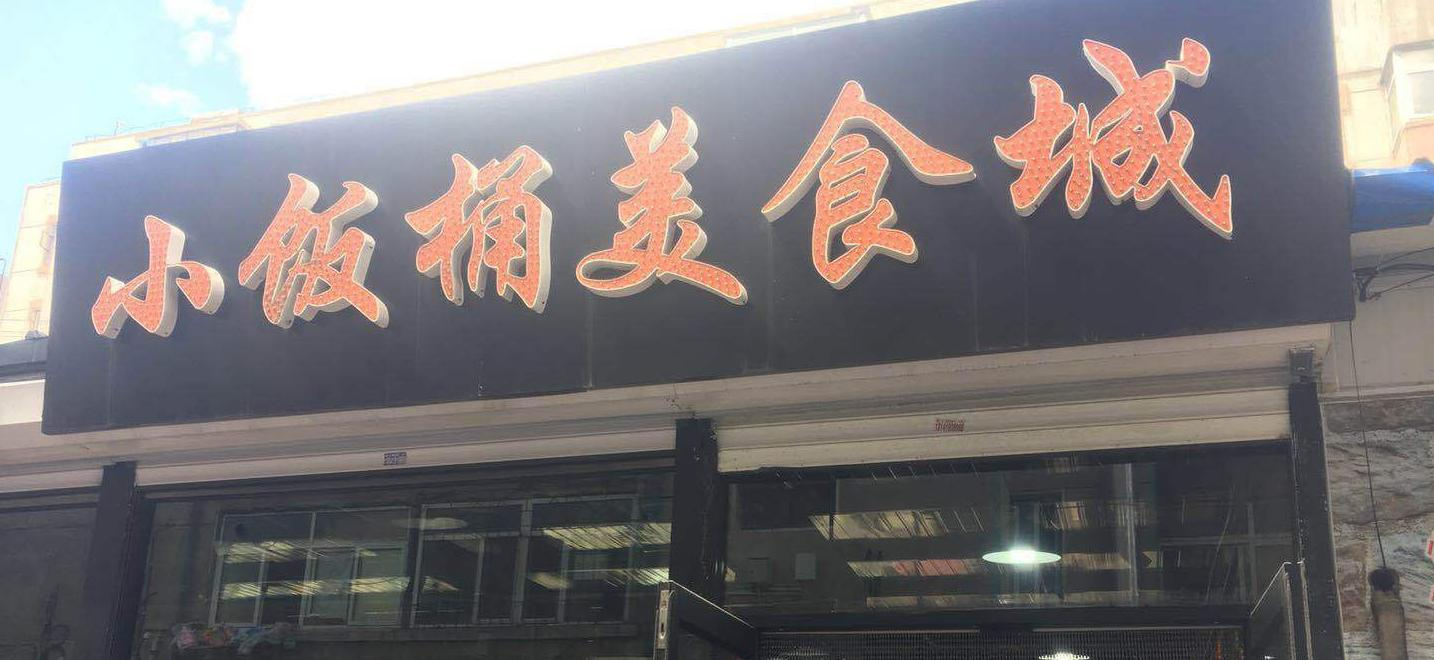

In [36]:
from IPython.display import display
from PIL import Image

img = Image.open(random_img_path)

display(img)

In [37]:
result = model.predict(random_img_path)

In [38]:
for i,res in enumerate(result):
    res.save_to_img(f"image_{i}")

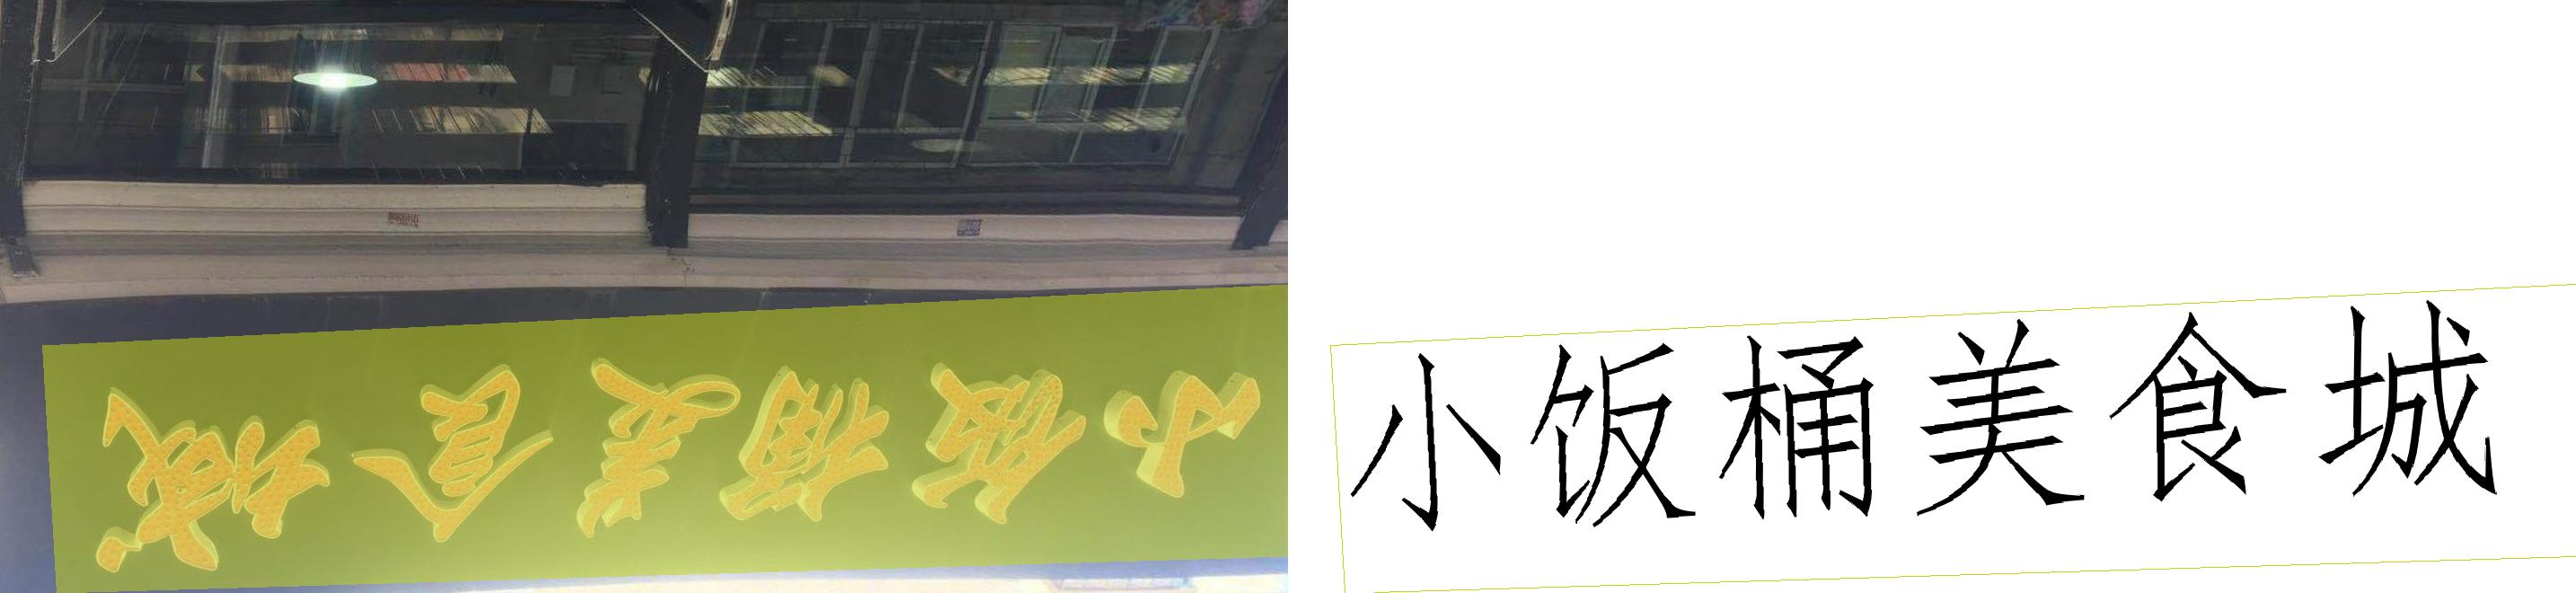

In [39]:
img = Image.open("/kaggle/working/image_0/train_ReCTS_019537_ocr_res_img.jpg")

display(img)

In [33]:
# !zip -q -r ReCTS_paddle_OCR_finetuned_inference.zip /kaggle/working/PP-OCRv5_server_rec_infer